<a herf="https://www.kaggle.com/ventureh/fraud-detection-using-keras-lstm-rnn"> Fraud Detection using Keras LSTM (RNN) <a>

In [53]:
import numpy as np
import pandas as pd
import pickle
import os, glob
import logging
import seaborn as sns

In [54]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import CSVLogger

In [56]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [57]:
path = os.getcwd()
path

'/home/m.shah/projects/models/kaggle-models'

## Loading Data

In [58]:
dfs = []

for filename in glob.glob(os.path.join(path, "../../data/simulated-data-raw/", "data", "*.pkl")):
    with open(filename, 'rb') as f:
        temp = pd.read_pickle(f)
        dfs.append(temp)
df = pd.DataFrame()
df = df.append(dfs)

In [59]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


## Preprocessing

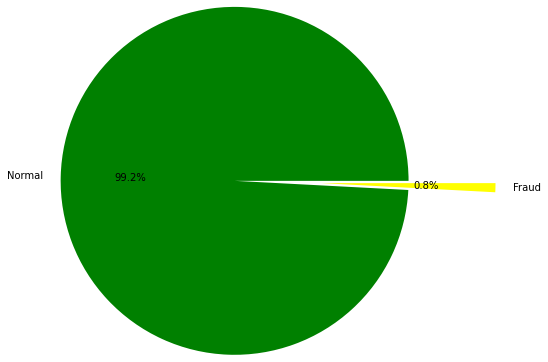

In [60]:
portions = df["TX_FRAUD"].value_counts().to_dict()
plt.pie(portions.values(), 
        portions.keys(),
        labels = ["Normal", "Fraud"], 
        radius = 2,
        autopct='%1.1f%%',
       colors = ["green", "yellow"])
plt.show()

In [1]:
column_names = list(['TX_AMOUNT'])
frauds = df[df['Class'] == 1]
no_frauds = df[df['Class'] == 0]

plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))
i = 0
for feature in column_names:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(frauds[feature])
    sns.kdeplot(no_frauds[feature])
    plt.xlabel(feature, fontsize=10)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();


NameError: name 'df' is not defined

In [62]:
customer_tx_count = df["CUSTOMER_ID"].value_counts().to_dict()

<AxesSubplot:ylabel='Density'>

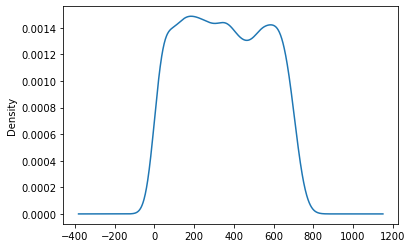

In [63]:
pd.Series(list(customer_tx_count.values())).plot(kind = 'density')

In [65]:
class PreProcessor:    
    def __init__(self, input_data):
        self.data = input_data
    
    def pre_process(self, 
                    feature_columns,
                    label_columns,
                    window_size = 3,
                    categoricals = None,
                    test_train_split = 0.7,
                    imbalanced = False):
        
        self.window_size = window_size
        self.test_train_split = test_train_split
        self.data_x = pd.DataFrame(self.data[feature_columns])
        self.data_y = pd.DataFrame(self.data[label_columns])
        self.n_features = len(feature_columns)
        self.n_labels = np.unique(self.data_y)

        #OneHotEncoding
        if categoricals is not None:
            self.encode(categoricals)
            with open("./log.txt", 'a') as log:
                log.write("Categorical features Encoded \n")

        #Rolling to make X and Y Tensors
        print("======== Making X and Y Tensors ==========")
        self.x_tensor, self.y_tensor = self.roll(self.window_size)
        print("Input X by shape:", self.data_x.shape,"is rolled to X Tensor: ", self.x_tensor.shape)
        with open("./log.txt", 'a') as log:
            log.write("X and Y tensors are Rolled \n")

        #Balance Data
        if imbalanced:
            self.train_idx = self.stratify()
            with open("./log.txt", 'a') as log:
                log.write("Data is Balanced \n")
        else:
            self.train_idx = np.random.choice(self.x_tensor.shape[0], 
                                          int(self.x_tensor.shape[0]*self.test_train_split), replace=False)
                      
        self.X_train = self.x_tensor[self.train_idx, :, :]
        self.X_test = np.delete(self.x_tensor, self.train_idx, axis=0)
        self.y_train = self.y_tensor[self.train_idx, ]
        self.y_test = np.delete(self.y_tensor, self.train_idx, axis=0)
        with open("./log.txt", 'a') as log:
            log.write("Preprocessing Done! \n")

        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def stratify(self):
        print("- - - - Balancing Data - - - -")
        y = np.vstack((range(len(self.y_tensor)),self.y_tensor.T)).T
        y_anomal = y[y[:,1]==1]
        y_normal = y[y[:,1]==0]
        y_anomal = y_anomal[np.random.choice(y_anomal.shape[0], max(int(y_anomal.shape[0]*self.test_train_split), 1), replace=False),:]
        y_normal = y_normal[np.random.choice(y_normal.shape[0], int(y_normal.shape[0]*self.test_train_split), replace=False),:]
        train_idx = np.array(np.hstack((y_anomal[:,0],y_normal[:,0])), dtype='int')
        return train_idx
            
    def encode(self, categoricals):
        if categoricals[0] is not None:
            self.data_x = pd.get_dummies(self.data_x, columns = categoricals[0])
            self.n_features = self.data_x.shape[1]
        if categoricals[1] is not None:
            self.data_y = pd.get_dummies(self.data_y, columns = categoricals[1])

    def roll(self, window_size):
        starts = np.array(range(self.data_x.shape[0]-(window_size)))
        if os.path.isfile('ix_tensor.pickle'):
            print("- - - -  X Tensor founded on Drive - - - - ")
            print("- - - -  Reading X TENSOR - - - - ")
            with open('ix_tensor.pickle', 'rb') as file:
                ix_tensor = pickle.load(file)
            with open('iy_tensor.pickle', 'rb') as file:
                iy_tensor = pickle.load(file)
        else:
            ix_tensor = np.zeros([(self.data_x.shape[0]-(window_size))*window_size, 
                                  self.n_features], dtype = 'float32')
            iy_tensor = np.zeros((0, len(self.n_labels)))
            
            #Rolling Loop for making ix_tensor
            for i in tqdm(range(self.data_x.shape[0]-(window_size))):
                s = np.array(self.data_x[i:i+window_size], dtype='float')
                ix_tensor[(window_size*i):(window_size*(i+1)), :] = s
                iy_tensor = np.vstack((iy_tensor, self.data_y.iloc[i+window_size, ]))
            ix_tensor = ix_tensor.reshape(-1, window_size, np.shape(ix_tensor)[1])
            print("- - - - Writing X Tensor on Drive- - - -")
            with open('ix_tensor.pickle', 'wb') as file:
                pickle.dump(ix_tensor, file)
            with open('iy_tensor.pickle', 'wb') as file:
                pickle.dump(iy_tensor, file)              
        return ix_tensor, iy_tensor

In [66]:
#Feature Define
if "WEEK_DAY" not in df.columns:
    df.insert(7, "WEEK_DAY", df["TX_DATETIME"].apply(lambda x : x.weekday()))

#Feature Selection
selected_features = ["CUSTOMER_ID", 
                     "TERMINAL_ID", 
                     'TX_AMOUNT', 
                     'TX_TIME_SECONDS', 
                     'TX_TIME_DAYS', 
                     "WEEK_DAY"]

In [16]:
pre_processor = PreProcessor(df.iloc[:,:9])
train_x, test_x, train_y, test_y = pre_processor.pre_process(selected_features, ["TX_FRAUD"],
                                                             window_size = 10, 
                                                             categoricals = [["WEEK_DAY"], ["TX_FRAUD"]],
                                                             imbalanced = True)

======== Making X and Y Tensors ==========
- - - -  X Tensor founded on Drive - - - - 
- - - -  Reading X TENSOR - - - - 
Input X by shape: (1754155, 12) is rolled to X Tensor:  (1754145, 10, 12)
- - - - Balancing Data - - - -


In [20]:
with open("pre_processor.pickle", 'wb') as preprocessor_file:
    pickle.dump(pre_processor, preprocessor_file)

In [21]:
#PARAMS
time_window = 128 

train_samples, n_features = df.shape[0], df.shape[1]
params = train_samples, time_window, n_features

# test_samples = test_x.shape[0]
# test_params =  test_samples, time_window, n_features


params

(1754155, 128, 10)

# Models

### Model 1: [ 2-layers: LSTM10 , Output2 ]

In [23]:
class LSTM_MODEL:
    def __init__(self,
                 input_shape,
                 n_outputs = 1):
        #Model Layers
        self.model = Sequential()
        self.model.add(LSTM(10, input_shape=input_shape,
                            kernel_initializer='lecun_uniform', 
                            activation='relu', 
                            kernel_regularizer=regularizers.l1(), 
                            recurrent_regularizer=regularizers.l1(0.01), 
                            bias_regularizer=None, 
                            activity_regularizer=None, 
                            dropout=0.2, recurrent_dropout=0.2))#, return_sequences=True))            
        self.model.add(Dropout(0.2))
        self.model.add(Dense(n_outputs, 
                             kernel_initializer='lecun_uniform',
                             activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', 
                           optimizer='adam', 
                           metrics=['accuracy']) #optimizer='rmsprop'
        self.model.build()
        print("Model Summary: \n\n", self.model.summary())
        self.model
        
    def train(self, train_x, train_y, batch_size = 100, epochs  =1):
        result = self.model.fit(train_x,
                                train_y, 
                                batch_size = batch_size, 
                                epochs = epochs)
        return result
    
#     def evaluate(self, train_x, train_y):
#         _, train_loss = self.model.evaluate(train_x, train_y)
#         print("Train Loss is: %f" %train_loss)
        
    def predict(self, test_x):
        return self.model.predict(test_x)

In [39]:
model = LSTM_MODEL(train_x.shape[1:], n_outputs = 2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                920       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________
Model Summary: 

 None


### Training

In [326]:
train_history = model.train(train_x, train_y, batch_size=1000, epochs=100)

with open("model_train_history.pickle", 'wb') as file:
    pickle.dump(train_history.history, file)

y_predicted = model.predict(test_x)

with open("model_y_predicted.pickle", 'wb') as file:
    pickle.dump(y_predicted, file)

with open('log.txt', 'a') as log:
    log.write("ended!")

Epoch 1/100
1228/1228 [==============================] - 105s 85ms/step - loss: 6557.3169 - accuracy: 0.9826
Epoch 2/100
1228/1228 [==============================] - 104s 85ms/step - loss: 191.3144 - accuracy: 0.9910
Epoch 3/100
1228/1228 [==============================] - 103s 84ms/step - loss: 108.1547 - accuracy: 0.9907
Epoch 4/100
1228/1228 [==============================] - 102s 83ms/step - loss: 95.3235 - accuracy: 0.9913
Epoch 5/100
1228/1228 [==============================] - 110s 89ms/step - loss: 80.9301 - accuracy: 0.9912
Epoch 6/100
1228/1228 [==============================] - 106s 86ms/step - loss: 71.3151 - accuracy: 0.9911
Epoch 7/100
1228/1228 [==============================] - 102s 83ms/step - loss: 149.8228 - accuracy: 0.9908
Epoch 8/100
1228/1228 [==============================] - 103s 84ms/step - loss: 53.3205 - accuracy: 0.9914
Epoch 9/100
1228/1228 [==============================] - 100s 81ms/step - loss: 46.3172 - accuracy: 0.9915
Epoch 10/100
1228/1228 [========

### Results

Accuracy

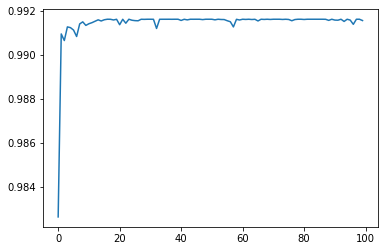

In [338]:
plt.plot(train_history.history['accuracy'])

Loss

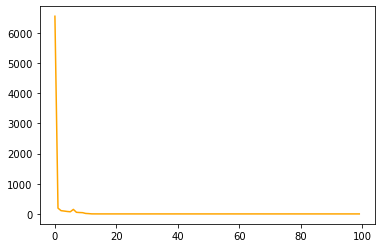

In [343]:
plt.plot(train_history.history['loss'], color = 'orange')

<b> AUC: </B> Area under RUC Curve

In [335]:
fpr, tpr, thresholds = metrics.roc_curve(np.argmax(test_y, axis =1), np.argmax(y_predicted, axis = 1), pos_label=1)
print('TEST | AUC Score: ' + str((metrics.auc(fpr, tpr))))


TEST | AUC Score: 0.5


F1-score

In [344]:
print(metrics.f1_score(np.argmax(test_y, axis =1), np.argmax(y_predicted, axis = 1)))

0.0


In [348]:
np.where(np.argmax(y_predicted, axis = 1)==1)

(array([], dtype=int64),)

In [351]:
pre_processor = PreProcessor(df.iloc[:,:9])
train_x, test_x, train_y, test_y = pre_processor.pre_process(selected_features, ["TX_FRAUD"],
                                                             window_size = 10, 
                                                             test_train_split = 0.5,
                                                             categoricals = [["WEEK_DAY"], ["TX_FRAUD"]],
                                                             imbalanced = True)

======== Making X and Y Tensors ==========
- - - -  X Tensor founded on Drive - - - - 
- - - -  Reading X TENSOR - - - - 
Input X by shape: (1754155, 12) is rolled to X Tensor:  (1754145, 10, 12)
- - - - Balancing Data - - - -


In [353]:
model2 = LSTM_MODEL(train_x.shape[1:], n_outputs = 2)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 10)                920       
_________________________________________________________________
dropout_24 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 22        
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________
Model Summary: 

 None


In [ ]:
train_history2 = model2.train(train_x, train_y, batch_size=256, epochs=100)

with open("model_train_history.pickle", 'wb') as file:
    pickle.dump(train_history2.history, file)

Epoch 1/100
3427/3427 [==============================] - 210s 60ms/step - loss: 25562.7356 - accuracy: 0.8458
Epoch 2/100
3427/3427 [==============================] - 204s 60ms/step - loss: 61.8674 - accuracy: 0.9888
Epoch 3/100
3427/3427 [==============================] - 205s 60ms/step - loss: 4.4144 - accuracy: 0.9887
Epoch 4/100
3427/3427 [==============================] - 209s 61ms/step - loss: 0.5634 - accuracy: 0.9904
Epoch 5/100
3427/3427 [==============================] - 209s 61ms/step - loss: 0.3497 - accuracy: 0.9911
Epoch 6/100
3427/3427 [==============================] - 211s 62ms/step - loss: 0.1726 - accuracy: 0.9915
Epoch 7/100
3427/3427 [==============================] - 205s 60ms/step - loss: 0.1177 - accuracy: 0.9914
Epoch 8/100
3427/3427 [==============================] - 203s 59ms/step - loss: 0.0815 - accuracy: 0.9914
Epoch 9/100
3427/3427 [==============================] - 197s 58ms/step - loss: 0.0616 - accuracy: 0.9915
Epoch 10/100
3427/3427 [=================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 191s 56ms/step - loss: 0.0660 - accuracy: 0.9916
Epoch 19/100
 341/3427 [=>............................] - ETA: 3:05 - loss: 0.0658 - accuracy: 0.9917

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 191s 56ms/step - loss: 0.0590 - accuracy: 0.9917
Epoch 21/100
 193/3427 [>.............................] - ETA: 3:04 - loss: 0.5183 - accuracy: 0.9926

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 210s 61ms/step - loss: 0.1067 - accuracy: 0.9916
Epoch 22/100
3427/3427 [==============================] - 192s 56ms/step - loss: 0.0658 - accuracy: 0.9916
Epoch 23/100
   7/3427 [..............................] - ETA: 3:18 - loss: 0.0707 - accuracy: 0.9893

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 188s 55ms/step - loss: 0.0583 - accuracy: 0.9917
Epoch 25/100
 861/3427 [======>.......................] - ETA: 2:22 - loss: 0.0610 - accuracy: 0.9916

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 189s 55ms/step - loss: 0.0624 - accuracy: 0.9916
Epoch 27/100
1202/3427 [=========>....................] - ETA: 2:06 - loss: 0.0581 - accuracy: 0.9915

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 191s 56ms/step - loss: 0.0646 - accuracy: 0.9916
Epoch 29/100
1774/3427 [==============>...............] - ETA: 1:31 - loss: 0.0756 - accuracy: 0.9913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 203s 59ms/step - loss: 0.0785 - accuracy: 0.9916
Epoch 31/100
1703/3427 [=============>................] - ETA: 1:42 - loss: 0.0654 - accuracy: 0.9913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 203s 59ms/step - loss: 0.0588 - accuracy: 0.9916
Epoch 33/100
1683/3427 [=============>................] - ETA: 1:44 - loss: 0.0606 - accuracy: 0.9916

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 206s 60ms/step - loss: 0.0542 - accuracy: 0.9918
Epoch 35/100
1672/3427 [=============>................] - ETA: 1:48 - loss: 0.0562 - accuracy: 0.9916

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 202s 59ms/step - loss: 0.0572 - accuracy: 0.9917
Epoch 37/100
2232/3427 [==================>...........] - ETA: 1:04 - loss: 0.0544 - accuracy: 0.9915

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - 190s 55ms/step - loss: 0.0668 - accuracy: 0.9915
Epoch 39/100
3085/3427 [==========================>...] - ETA: 18s - loss: 0.0582 - accuracy: 0.9919

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3427/3427 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.99 - 202s 59ms/step - loss: 0.0587 - accuracy: 0.9917
Epoch 41/100
1310/3427 [==========>...................] - ETA: 3:56:46 - loss: 0.0559 - accuracy: 0.9918ETA: 1 - ETA: 31:42 - loss: 0.0552 - ac - ETA: 40:32 - loss: 0.0555 - accuracy: - ETA: 42:08 - loss: 0.0555 - accuracy: 0.9 - ETA: 42:30 - loss: 0.0555 - accuracy: 0. - ETA: 42:58 - loss: 0.0555 - accuracy: 0.991 - ETA: 43:22 - loss: 0.0555 - accuracy: 0.99 - ETA: 44:32 - loss: 0.0555 - accuracy:  - ETA: 47:04 - loss: 0.0555 - accuracy - ETA: 49:39 - loss: 0.0555 - accuracy: 0.99 - ETA: 50:58 - loss: 0.0556 - accuracy: 0.991 - ETA: 51:18 - loss: 0.0556 - accuracy:  - ETA: 55:20 - loss: 0.0 - ETA: 55:20 - loss: 0.0556 - accuracy: 0. - ETA: 57:17 - loss: 0.0556 - accuracy: 0. - ETA: 59:07 - loss: 0.0556 - accuracy: 0.991 - ETA: 59:19 - loss: 0.0556 - accuracy: 0.99 - ETA: 59:46 - loss: 0.0556 - accuracy: 0. - ETA: 1:01:40 - loss: 0.0557 - accuracy: 0.9

In [35]:
y_predicted2 = model2.predict(test_x)

with open("model_y_predicted.pickle", 'wb') as file:
    pickle.dump(y_predicted2, file)

with open('log.txt', 'a') as log:
    log.write("ended!")

## Transaction Prediction

In [72]:
class LSTM_REGRESSION:
    def __init__(self,
                 input_shape,
                 lstm_units = 80,
                 n_outputs = 1):
        #Model Layers
        self.model = Sequential()
        self.model.add(LSTM(lstm_units, input_shape=input_shape, return_sequence = True))#, return_sequences=True))            
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(lstm_units, return_sequence = True))            
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(lstm_units))            
        self.model.add(Dropout(0.2))
        self.model.add(Dense(n_outputs))
        
        self.model.compile(loss='mse', 
                           optimizer='adam', 
                           metrics=['accuracy']) #optimizer='rmsprop'
        self.model.build()
        print("Model Summary: \n\n", self.model.summary())
        self.model
        
    def train(self, train_x, train_y, batch_size = 100, epochs  =1):
        result = self.model.fit(train_x,
                                train_y, 
                                batch_size = batch_size, 
                                epochs = epochs)
        return result
    def predict(self, test_x):
        return self.model.predict(test_x)

In [79]:
prep = PreProcessor(df.iloc[:200,:9])
train_x, test_x, train_y, test_y = prep.pre_process(selected_features, selected_features)

======== Making X and Y Tensors ==========
- - - -  X Tensor founded on Drive - - - - 
- - - -  Reading X TENSOR - - - - 
Input X by shape: (200, 6) is rolled to X Tensor:  (1754145, 10, 12)


In [80]:
train_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])